# North Atlantic Winter Weather Regimes: K-means Clustering
* Wenchang Yang (yang.wenchang@uci.edu)

Apply the k-means clustering on the NCEP/NCAR reanalysis 500hPa geopotential height (Z500) anomalies to get the North Atlantic winter weather regimes, including:
* NAO+ (positive NAO) 
* NAO- (negative NAO)
* Blocking 
* Atlantic Ridge. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# personal packages
from xlearn.cluster import KMeans
from pyingrid import Ingrid
import geoxarray

%matplotlib inline

## The data is from the [Columbia University IRI data library](http://iridl.ldeo.columbia.edu)

In [2]:
ig = Ingrid('http://iridl.ldeo.columbia.edu',
            'SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY',
            '.Intrinsic/.PressureLevel/.phi')\
    .do('P(500)VALUES') \
    .do('T(Dec 1979)(Mar 2010)RANGE')\
    .do('yearly-anomalies') \
    .do('T(Dec)(Jan)(Feb)(Mar)VALUES')\
    .do('X -90 2 60 GRID Y 80 -2 20 GRID')
print(ig)
print('\n[Final data URL]:\n', ig.to_url())

<class 'pyingrid.ingrid.Ingrid'>
http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi
	P(500)VALUES
	T(Dec 1979)(Mar 2010)RANGE
	yearly-anomalies
	T(Dec)(Jan)(Feb)(Mar)VALUES
	X -90 2 60 GRID Y 80 -2 20 GRID

[Final data URL]:
 http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP-NCAR/.CDAS-1/.MONTHLY/.Intrinsic/.PressureLevel/.phi/P(500)VALUES/T(Dec%201979)(Mar%202010)RANGE/yearly-anomalies/T(Dec)(Jan)(Feb)(Mar)VALUES/X%20-90%202%2060%20GRID%20Y%2080%20-2%2020%20GRID


## Convert the data from the library into an xarray Dataset

In [3]:
ds = ig.to_dataset()
print(ds)

<xarray.Dataset>
Dimensions:  (P: 1, T: 124, X: 76, Y: 31)
Coordinates:
  * P        (P) int32 500
  * T        (T) datetime64[ns] 1979-12-01 1980-12-01 1981-12-01 1982-12-01 ...
  * X        (X) float32 -90.0 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * Y        (Y) float32 80.0 78.0 76.0 74.0 72.0 70.0 68.0 66.0 64.0 62.0 ...
Data variables:
    phi      (T, P, Y, X) float32 ...
Attributes:
    Conventions: IRIDL


## Get the DataArray and load it into memory

In [4]:
da = ds.sel(P=500).phi.load()
print(da.name, da.dims)
print(da.coords)

phi ('T', 'Y', 'X')
Coordinates:
    P        int32 500
  * T        (T) datetime64[ns] 1979-12-01 1980-12-01 1981-12-01 1982-12-01 ...
  * X        (X) float32 -90.0 -88.0 -86.0 -84.0 -82.0 -80.0 -78.0 -76.0 ...
  * Y        (Y) float32 80.0 78.0 76.0 74.0 72.0 70.0 68.0 66.0 64.0 62.0 ...


## Perform the k-means clustering

In [5]:
m = KMeans(n_clusters=4, random_state=0, n_jobs=-1).fit(da)
print(m)

[KMeans for xarray]: algorithm="auto", copy_x=True, init="k-means++", max_iter=300, n_clusters=4, n_init=10, n_jobs=-1, precompute_distances="auto", random_state=0, tol=0.0001, verbose=0.


## Show the results

/home/wenchay/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3630: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/wenchay/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3699: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/home/wenchay/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3527: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/wenchay/miniconda3/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3594: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


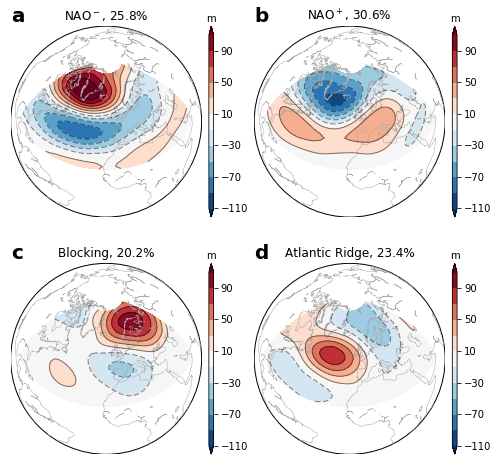

In [6]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
regimes = ['NAO$^-$', 'NAO$^+$', 'Blocking', 'Atlantic Ridge']
tags = list('abcd')
for i in range(m.n_clusters):
    m.plot_cluster_centers(label=i, 
        proj='ortho', 
        plot_type='contourf+', 
        levels=np.arange(-110, 111, 20),
        units='m',
        ax=axes.flat[i])
    title = '{}, {}'.format(regimes[i],
                            axes.flat[i].title.get_text())
    plt.title(title)
    plt.text(0, 1, tags[i], 
             transform=axes.flat[i].transAxes, 
             va='bottom', 
             fontsize=plt.rcParams['font.size']*2, 
             fontweight='bold')
    